# COMP 551 P2 D1
https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset

## Data cleaning

In [2]:
import numpy as np
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=['headers', 'footers', 'quotes'])
newsgroups_train.target.shape

(11314,)

In [4]:
delchars = ''.join(c for c in map(chr, range(256)) if not c.isalpha())
delchars = ''.join(ch for ch in delchars if ch !=' ')
def clean_text(paragraph):
    output = re.sub('\<.*?\>','', paragraph) #delete tags (between <..>)
    output = re.sub('\@.*?\s','', output) #delete usernames (words following @)
    output = re.sub('\n','', output) #delete anything following a slash
    output = output.translate(str.maketrans('','',delchars))
    output = output.strip()
    return output

newsgroups_train.data = list(map(lambda x: clean_text(x), newsgroups_train.data))
remove_index = []
data = []
for i, x in enumerate(newsgroups_train.data):
    if (x == ""):
        remove_index.append(i)
    else:
        data.append(x)
newsgroups_train.data = data

In [5]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(newsgroups_train.data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
x_train = X_train_tfidf
x_train.shape

(11003, 154809)

In [6]:
target = []
for i in range(len(newsgroups_train.target)): 
    if i not in remove_index:
        target.append(newsgroups_train.target[i])
y_train = target
len(y_train)

11003

In [7]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=['headers', 'footers', 'quotes'])
X_new_counts = count_vect.transform(newsgroups_test.data)
x_test = tfidf_transformer.transform(X_new_counts)
x_test.shape

(7532, 154809)

In [8]:
y_test = newsgroups_test.target
y_test.shape

(7532,)

## Naive Bayes Implementation

In [9]:
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1234)

In [10]:
class MultinomialNaiveBayes:
  def __init__(self, alpha=1):
    self.alpha = alpha 

  def fit(self, X_train, y_train):
      m, n = X_train.shape
      self._classes = np.unique(y_train)
      n_classes = len(self._classes)

    # init: Prior & Likelihood
      self._priors = np.zeros(n_classes)
      self._likelyhoods = np.zeros((n_classes, n))

    # Get Prior and Likelihood
      for idx, c in enumerate(self._classes):
          X_train_c = X_train[c == y_train]
          self._priors[idx] = X_train_c.shape[0] / m 
          self._likelyhoods[idx, :] = ((X_train_c.sum(axis=0)) + self.alpha) / (np.sum(X_train_c.sum(axis=0) + self.alpha))


  def predict(self, X_test):
      return [self._predict(x_test) for x_test in X_test]

  def _predict(self, x_test):
      #Calculate posterior for each class
      posteriors = []
      for idx, c in enumerate(self._classes):
          prior_c = np.log(self._priors[idx])
          likelyhoods_c = self.calc_likelyhood(self._likelyhoods[idx,:], x_test.toarray())

          posteriors_c = np.sum(likelyhoods_c) + prior_c
          posteriors.append(posteriors_c)
      #print(self._classes[np.argmax(posteriors)])
      return self._classes[np.argmax(posteriors)]

  def calc_likelyhood(self, cls_likely, x_test):
      return np.log(cls_likely) * x_test

  def score(self, X_test, y_test):
      y_pred = self.predict(X_test)
      return np.sum(y_pred == y_test)/len(y_test)


### Cross Validation

In [ ]:
def evaluate_acc(actual, pred):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == pred[i]: correct += 1
    return correct / len(actual)


def cross_validation_split(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds


n_train = x_train.shape[0]
num_folds = 5
acc_val = np.zeros(num_folds)
def kfoldCV(a):
    for f, (tr, val) in enumerate(cross_validation_split(n_train, num_folds)):
        model = MultinomialNaiveBayes(alpha=a)
        model.fit(X_train=x_train.tocsr()[tr,:], y_train=np.array(y_train)[tr])
        y_prob = model.predict(x_train.tocsr()[val,:])
        # print(evaluate_acc(np.array(y_train)[val], y_prob))
        acc_val[f] = evaluate_acc(np.array(y_train)[val], y_prob)
    return acc_val


alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
res = []
for a in alphas:
    b = kfoldCV(a)
    # print(b)
    res.append(list(b)[:])

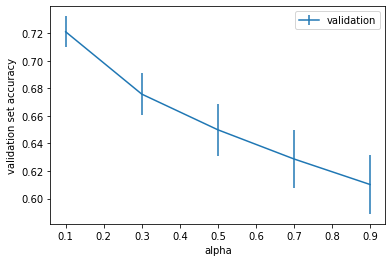

In [ ]:
plt.errorbar(alphas, np.mean(res, axis=1), np.std(res, axis=1), label='validation')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('validation set accuracy')
plt.show()

### Test Accuracy for NB

In [11]:
def evaluate_acc(actual, pred):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == pred[i]: correct += 1
    return correct / len(actual)
    
def evaluate_acc_test():
    model = MultinomialNaiveBayes(alpha=0.1)
    model.fit(X_train=x_train, y_train = y_train)
    y_prob = model.predict(x_test)
    y_pred = y_prob
    accuracy = evaluate_acc(y_pred, y_test)
    print(f'test accuracy: {accuracy}')


evaluate_acc_test()

test accuracy: 0.6607806691449815


## Logistic Regression


In [12]:
def logistic(t):
    n = x_train.shape[0]
    n *= 0.8 # number for train, remaining for validation
    n = int(n)
    clf = LogisticRegression(tol=t).fit(x_train.tocsr()[range(0,n),:], np.array(y_train)[range(0,n)])
    res = clf.predict(x_train.tocsr()[range(n,x_train.shape[0]-1),:])
    return evaluate_acc(np.array(y_train)[range(n,x_train.shape[0]-1)], res)

In [13]:
tols = [0.001, 0.01, 0.1, 1, 10, 100]
acc_log = []
for t in tols:
    acc_log.append(logistic(t))
print(acc_log)

[0.6845454545454546, 0.6845454545454546, 0.6845454545454546, 0.6845454545454546, 0.6836363636363636, 0.07681818181818181]


In [14]:
def logistic_test_set():
    clf = LogisticRegression(tol=0.001).fit(x_train, y_train)
    res = clf.predict(x_test)
    return evaluate_acc(y_test, res)


logistic_test_set()

0.6463090812533192

## Task 3.3

In [ ]:
def evaluate_acc_with_diff_train(percent):
    N = x_train.shape[0]
    inds = np.random.permutation(N)
    inds = inds[:int(N*percent)]
    model = MultinomialNaiveBayes(alpha=0.1)
    model.fit(X_train = x_train.tocsr()[inds,:], y_train = np.array(y_train)[inds])
    y_prob = model.predict(x_test)
    y_pred = y_prob
    accuracy = evaluate_acc(y_pred, y_test)
    # print(f'test accuracy: {accuracy}')
    return accuracy


percent = [0.2, 0.4, 0.6, 0.8]
accs_NB = []
for p in percent:
    acc = evaluate_acc_with_diff_train(p)
    accs_NB.append(acc)

In [15]:
from sklearn.naive_bayes import MultinomialNB
def evaluate_acc_with_diff_train(percent):
    N = x_train.shape[0]
    inds = np.random.permutation(N)
    inds = inds[:int(N*percent)]
    model = MultinomialNB(alpha=0.1)
    model.fit(x_train.tocsr()[inds,:], np.array(y_train)[inds])
    y_prob = model.predict(x_test)
    y_pred = y_prob
    accuracy = evaluate_acc(y_pred, y_test)
    # print(f'test accuracy: {accuracy}')
    return accuracy


percent = [0.2, 0.4, 0.6, 0.8]
accs_NB = []
for p in percent:
    acc = evaluate_acc_with_diff_train(p)
    accs_NB.append(acc)

In [16]:
def evaluate_acc_with_diff_train_LR(percent):
    N = x_train.shape[0]
    inds = np.random.permutation(N)
    inds = inds[:int(N*percent)]
    y_prob = LogisticRegression(tol=0.0001).fit(x_train.tocsr()[inds,:], np.array(y_train)[inds]).predict(x_test)
    y_pred = y_prob
    accuracy = evaluate_acc(y_pred, y_test)
    # print(f'test accuracy: {accuracy}')
    return accuracy


percent = [0.2, 0.4, 0.6, 0.8]
accs_LR = []
for p in percent:
    acc = evaluate_acc_with_diff_train_LR(p)
    accs_LR.append(acc)

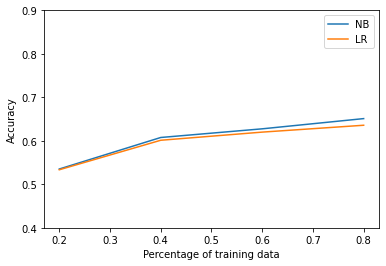

In [18]:
plt.plot(percent, accs_NB,  label='NB')
plt.plot(percent, accs_LR,  label='LR')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Percentage of training data')
plt.ylim(0.4, 0.9)
plt.show()